In [2]:
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Model
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pylab
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from statsmodels.tsa.api import ExponentialSmoothing
import xgboost as xgb

In [3]:
df = pd.read_csv("retail_store_inventory.csv")
df["Date"] = pd.to_datetime(df["Date"], errors='coerce') #handle datatype 

store1=df[df["Store ID"]=="S001"]
store2=df[df["Store ID"]=="S002"]
store3=df[df["Store ID"]=="S003"]
store4=df[df["Store ID"]=="S004"]
store5=df[df["Store ID"]=="S005"]

data=store1 # 1. store 

sp1 = data.groupby(['Date','Product ID']).sum()
sp1_filtered = sp1.loc[sp1.index.get_level_values('Product ID') == 'P0001']
sp1_filtered_reset = sp1_filtered.reset_index(level='Product ID', drop=True)
unit = sp1_filtered_reset[['Units Sold']]

/var/folders/_z/0s1nj30n17q95bnhv10ll0500000gn/T/ipykernel_22993/2034747233.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sp1 = data.groupby(['Date','Product ID']).sum()


In [4]:
data['year'] = pd.to_datetime(data['Date']).dt.year
data['month'] = pd.to_datetime(data['Date']).dt.month
data['day'] = pd.to_datetime(data['Date']).dt.day
data['day_of_year'] = pd.to_datetime(data['Date']).dt.dayofyear
data['week_of_year'] = pd.to_datetime(data['Date']).dt.isocalendar().week
data['quarter'] = pd.to_datetime(data['Date']).dt.quarter
data['season'] = (data['month'] % 12 // 3 + 1)
data

/var/folders/_z/0s1nj30n17q95bnhv10ll0500000gn/T/ipykernel_22993/1424938003.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['year'] = pd.to_datetime(data['Date']).dt.year
/var/folders/_z/0s1nj30n17q95bnhv10ll0500000gn/T/ipykernel_22993/1424938003.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['month'] = pd.to_datetime(data['Date']).dt.month
/var/folders/_z/0s1nj30n17q95bnhv10ll0500000gn/T/ipykernel_22993/1424938003.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Date Store ID Product ID     Category Region  Inventory Level  \
0     2022-01-01     S001      P0001    Groceries  North              231   
1     2022-01-01     S001      P0002         Toys  South              204   
2     2022-01-01     S001      P0003         Toys   West              102   
3     2022-01-01     S001      P0004         Toys  North              469   
4     2022-01-01     S001      P0005  Electronics   East              166   
...          ...      ...        ...          ...    ...              ...   
73015 2024-01-01     S001      P0016  Electronics   East               74   
73016 2024-01-01     S001      P0017         Toys   East              282   
73017 2024-01-01     S001      P0018  Electronics   East              191   
73018 2024-01-01     S001      P0019     Clothing   West              149   
73019 2024-01-01     S001      P0020  Electronics  South              242   

       Units Sold  Units Ordered  Demand Forecast  Price  ...  \
0             127             55           135.47  33.50  ...   
1             150             66           144.04  63.01  ...   
2              65             51            74.02  27.99  ...   
3              61            164            62.18  32.72  ...   
4              14            135             9.26  73.64  ...   
...           ...            ...              ...    ...  ...   
73015          13            189            27.53  40.61  ...   
73016         186             61           201.40  20.68  ...   
73017          29             95            25.01  24.10  ...   
73018         145             85           154.83  81.71  ...   
73019          52            198            50.82  11.00  ...   

       Holiday/Promotion Competitor Pricing  Seasonality  year month  day  \
0                      0              29.69       Autumn  2022     1    1   
1                      0              66.16       Autumn  2022     1    1   
2                      1              31.32       Summer  2022     1    1   
3                      1              34.74       Autumn  2022     1    1   
4                      0              68.95       Summer  2022     1    1   
...                  ...                ...          ...   ...   ...  ...   
73015                  1              35.76       Summer  2024     1    1   
73016                  0              17.23       Winter  2024     1    1   
73017                  1              23.13       Winter  2024     1    1   
73018                  0              80.86       Spring  2024     1    1   
73019                  0               7.46       Spring  2024     1    1   

       day_of_year  week_of_year  quarter  season  
0                1            52        1       1  
1                1            52        1       1  
2                1            52        1       1  
3                1            52        1       1  
4                1            52        1       1  
...            ...           ...      ...     ...  
73015            1             1        1       1  
73016            1             1        1       1  
73017            1             1        1       1  
73018            1             1        1       1  
73019            1             1        1       1  

[14620 rows x 22 columns]

/var/folders/_z/0s1nj30n17q95bnhv10ll0500000gn/T/ipykernel_22993/1076399893.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['month_sin'] = np.sin(2*np.pi*data.month/12)  # Encoding month
/var/folders/_z/0s1nj30n17q95bnhv10ll0500000gn/T/ipykernel_22993/1076399893.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['month_cos'] = np.cos(2*np.pi*data.month/12)
/var/folders/_z/0s1nj30n17q95bnhv10ll0500000gn/T/ipykernel_22993/1076399893.py:5: SettingWithCopyWarning: 
A value is trying to be set on 

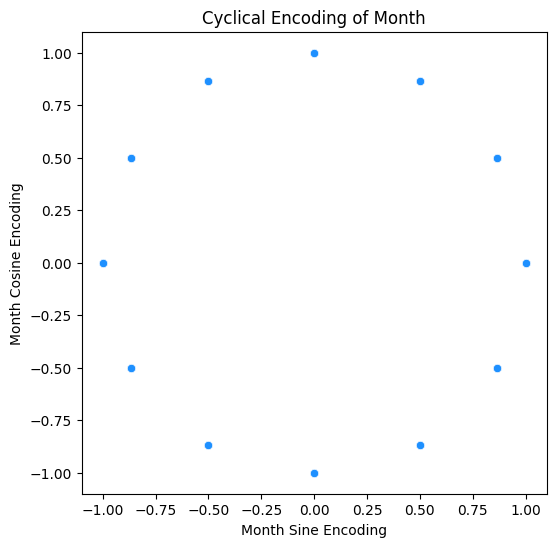

In [5]:
days_in_month = 30
data['month_sin'] = np.sin(2*np.pi*data.month/12)  # Encoding month
data['month_cos'] = np.cos(2*np.pi*data.month/12)

data['day_sin'] = np.sin(2*np.pi*data.day/days_in_month)
data['day_cos'] = np.cos(2*np.pi*data.day/days_in_month)

days_in_year = 365
data['day_of_year_sin'] = np.sin(2*np.pi*data.day_of_year/days_in_year)
data['day_of_year_cos'] = np.cos(2*np.pi*data.day_of_year/days_in_year)

weeks_in_year = 52.1429
data['week_of_year_sin'] = np.sin(2*np.pi*data.week_of_year/weeks_in_year)
data['week_of_year_cos'] = np.cos(2*np.pi*data.week_of_year/weeks_in_year)

quarters_in_year = 4
data['quarter_sin'] = np.sin(2*np.pi*data.quarter/quarters_in_year)
data['quarter_cos'] = np.cos(2*np.pi*data.quarter/quarters_in_year)

seasons_in_year = 4
data['season_sin'] = np.sin(2*np.pi*data.season/seasons_in_year)
data['season_cos'] = np.cos(2*np.pi*data.season/seasons_in_year)

# Plotting the scatter plot for the month feature encoding
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
sns.scatterplot(x=data.month_sin, y=data.month_cos, color='dodgerblue')

# Display the plot
plt.title("Cyclical Encoding of Month")
plt.xlabel("Month Sine Encoding")
plt.ylabel("Month Cosine Encoding")
plt.show()

In [6]:
split_date = "2023-06-06"
train = data.loc[data.Date <= split_date].copy()
test = data.loc[data.Date > split_date].copy()

In [7]:
train_float=train.select_dtypes(include="float64") #float64 columns
test_float=test.select_dtypes(include="float64") 

In [14]:
train_float = train_float.drop(['Demand Forecast','Price','Competitor Pricing'], axis=1)

In [15]:
test_float = test_float.drop(['Demand Forecast','Price','Competitor Pricing'], axis=1)

In [16]:
X_train,y_train=train_float,train["Units Sold"]  #X_train columns are selected for train model
X_test,y_test=test_float,test["Units Sold"]

In [18]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train, verbose=True) # Change verbose to True if you want to see it train

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

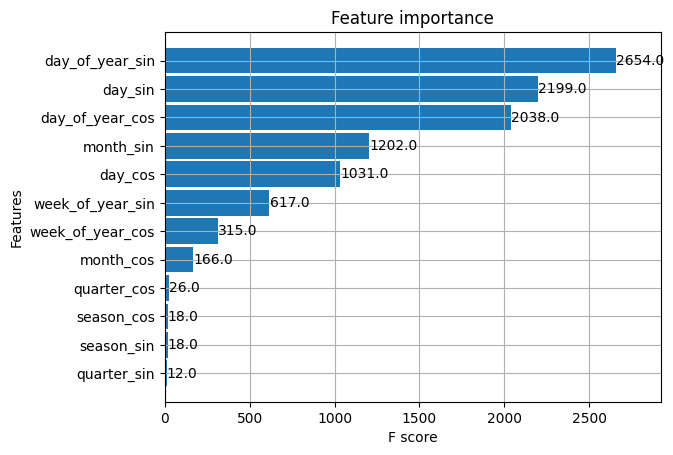

In [19]:
xgb.plot_importance(reg, height=0.9)

In [20]:
test["predicted_unit"]=reg.predict(X_test)

data_all=pd.concat([train,test],sort=False)
data_all

Date Store ID Product ID     Category Region  Inventory Level  \
0     2022-01-01     S001      P0001    Groceries  North              231   
1     2022-01-01     S001      P0002         Toys  South              204   
2     2022-01-01     S001      P0003         Toys   West              102   
3     2022-01-01     S001      P0004         Toys  North              469   
4     2022-01-01     S001      P0005  Electronics   East              166   
...          ...      ...        ...          ...    ...              ...   
73015 2024-01-01     S001      P0016  Electronics   East               74   
73016 2024-01-01     S001      P0017         Toys   East              282   
73017 2024-01-01     S001      P0018  Electronics   East              191   
73018 2024-01-01     S001      P0019     Clothing   West              149   
73019 2024-01-01     S001      P0020  Electronics  South              242   

       Units Sold  Units Ordered  Demand Forecast  Price  ...   day_cos  \
0             127             55           135.47  33.50  ...  0.978148   
1             150             66           144.04  63.01  ...  0.978148   
2              65             51            74.02  27.99  ...  0.978148   
3              61            164            62.18  32.72  ...  0.978148   
4              14            135             9.26  73.64  ...  0.978148   
...           ...            ...              ...    ...  ...       ...   
73015          13            189            27.53  40.61  ...  0.978148   
73016         186             61           201.40  20.68  ...  0.978148   
73017          29             95            25.01  24.10  ...  0.978148   
73018         145             85           154.83  81.71  ...  0.978148   
73019          52            198            50.82  11.00  ...  0.978148   

      day_of_year_sin  day_of_year_cos  week_of_year_sin week_of_year_cos  \
0            0.017213         0.999852         -0.017219         0.999852   
1            0.017213         0.999852         -0.017219         0.999852   
2            0.017213         0.999852         -0.017219         0.999852   
3            0.017213         0.999852         -0.017219         0.999852   
4            0.017213         0.999852         -0.017219         0.999852   
...               ...              ...               ...              ...   
73015        0.017213         0.999852          0.120208         0.992749   
73016        0.017213         0.999852          0.120208         0.992749   
73017        0.017213         0.999852          0.120208         0.992749   
73018        0.017213         0.999852          0.120208         0.992749   
73019        0.017213         0.999852          0.120208         0.992749   

       quarter_sin   quarter_cos  season_sin    season_cos  predicted_unit  
0              1.0  6.123234e-17         1.0  6.123234e-17             NaN  
1              1.0  6.123234e-17         1.0  6.123234e-17             NaN  
2              1.0  6.123234e-17         1.0  6.123234e-17             NaN  
3              1.0  6.123234e-17         1.0  6.123234e-17             NaN  
4              1.0  6.123234e-17         1.0  6.123234e-17             NaN  
...            ...           ...         ...           ...             ...  
73015          1.0  6.123234e-17         1.0  6.123234e-17      137.582336  
73016          1.0  6.123234e-17         1.0  6.123234e-17      137.582336  
73017          1.0  6.123234e-17         1.0  6.123234e-17      137.582336  
73018          1.0  6.123234e-17         1.0  6.123234e-17      137.582336  
73019          1.0  6.123234e-17         1.0  6.123234e-17      137.582336  

[14620 rows x 35 columns]

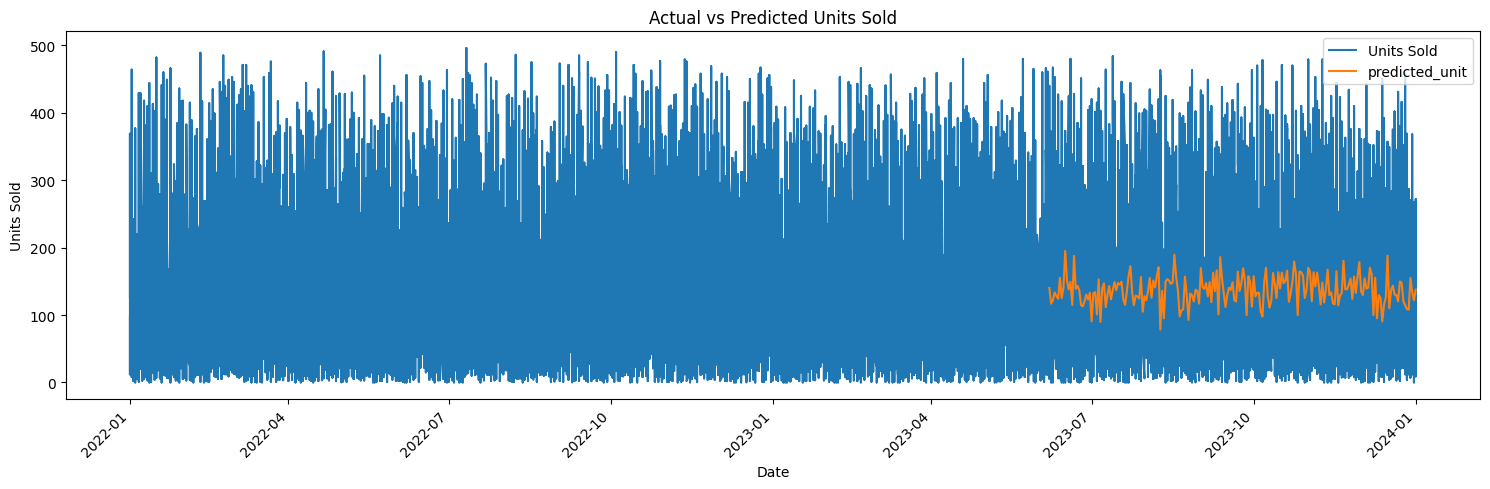

In [21]:
data_all.set_index('Date')[["Units Sold","predicted_unit"]].plot(figsize=(15,5), title='Actual vs Predicted Units Sold')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [22]:
mae = mean_absolute_error(test['Units Sold'], test['predicted_unit'])
rmse = np.sqrt(mean_squared_error(test['Units Sold'], test['predicted_unit']))
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")

Mean Absolute Error: 90.92915704900568
Root Mean Squared Error: 111.27720893193266


In [23]:
def plot_each_product_demand(df,product):
    dataf=df[df["Product ID"]==product]
    
    #split data
    
    split_date = "2023-06-06"
    train = dataf.loc[dataf.Date <= split_date]
    test = dataf.loc[dataf.Date > split_date]
   
    # select float 64 column for model
    
    train_float=train.select_dtypes(include=["float64","int32","int64"]) #float64 columns
    test_float=test.select_dtypes(include=["float64","int32","int64"]) 
    train_float = train_float.drop(['Demand Forecast','Price','Competitor Pricing'], axis=1)
    test_float = test_float.drop(['Demand Forecast','Price','Competitor Pricing'], axis=1)
    X_train,y_train=train_float.drop(columns=["Units Sold"],axis=1),train["Units Sold"]  #X_train columns are selected for train model
    X_test,y_test=test_float.drop(columns=["Units Sold"],axis=1),test["Units Sold"]
    
    #xgboost model training
    
    reg = xgb.XGBRegressor(n_estimators=1000)
    reg.fit(X_train, y_train,
       verbose=False)# Change verbose to True if you want to see it train
    
    #predicting
    
    test["predicted_sold"]=reg.predict(X_test)
   
    data_product=pd.concat([train,test],sort=False)
    
    #visualizing
    
    data_product.set_index('Date')[["Units Sold", "predicted_sold"]].plot(figsize=(15,5), title=f"Actual vs Predicted Units Sold  for {product}")
    plt.xlabel('Date')
    plt.ylabel(f'Inventory Level for {product}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    #mae 
    
    mae_current=mean_absolute_error(test['predicted_sold'], test['Units Sold'])
    print()
    print(f"Mean Squared Error for  {product}={mae_current}")
    print()
    return data_product

In [24]:
def unique_values(df,column_id):
    array=df[column_id].unique()
    list=sorted(array.tolist())
    return list

/var/folders/_z/0s1nj30n17q95bnhv10ll0500000gn/T/ipykernel_22993/2343077967.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["predicted_sold"]=reg.predict(X_test)


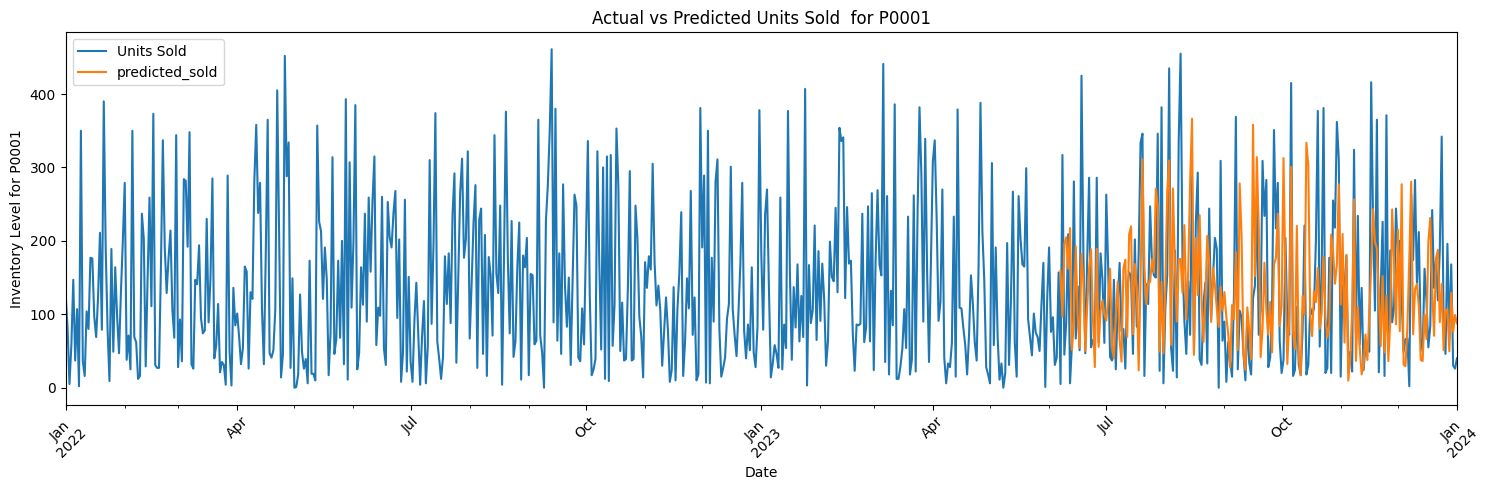


Mean Squared Error for  P0001=83.53619519831462



/var/folders/_z/0s1nj30n17q95bnhv10ll0500000gn/T/ipykernel_22993/2343077967.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["predicted_sold"]=reg.predict(X_test)


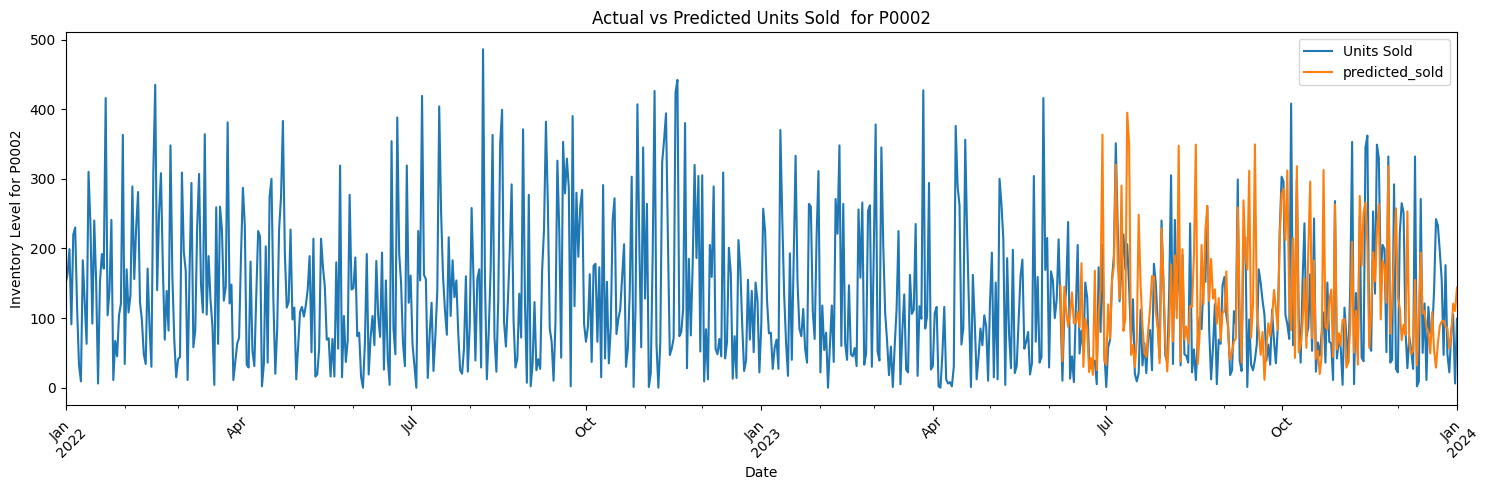


Mean Squared Error for  P0002=65.50478895543294



/var/folders/_z/0s1nj30n17q95bnhv10ll0500000gn/T/ipykernel_22993/2343077967.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["predicted_sold"]=reg.predict(X_test)


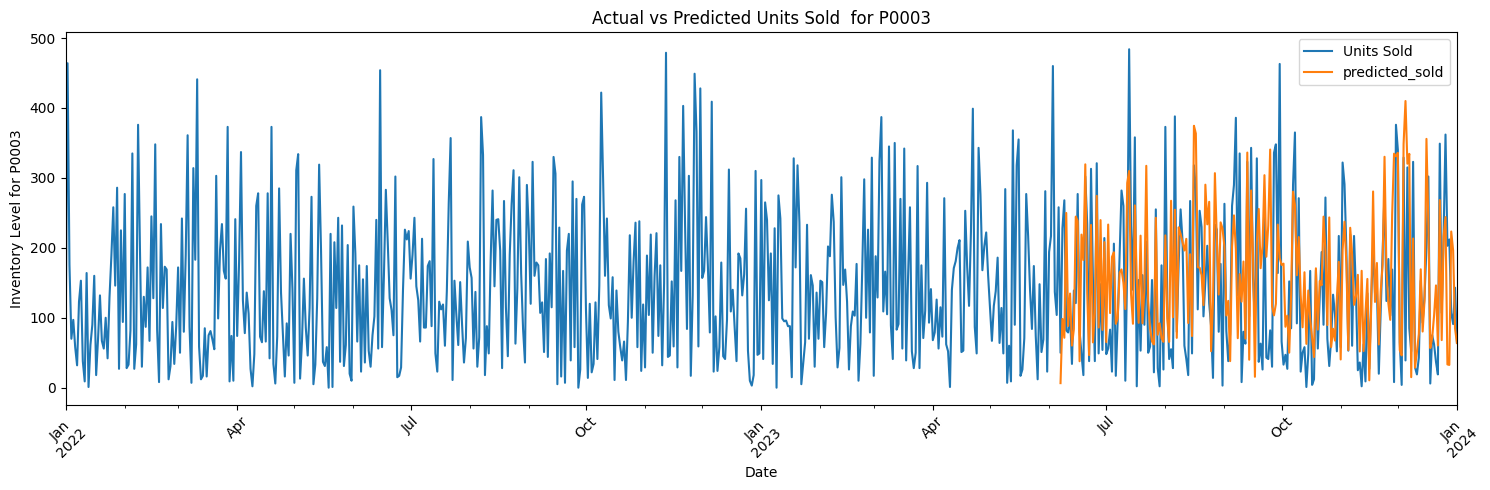


Mean Squared Error for  P0003=77.63752659428063



/var/folders/_z/0s1nj30n17q95bnhv10ll0500000gn/T/ipykernel_22993/2343077967.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["predicted_sold"]=reg.predict(X_test)


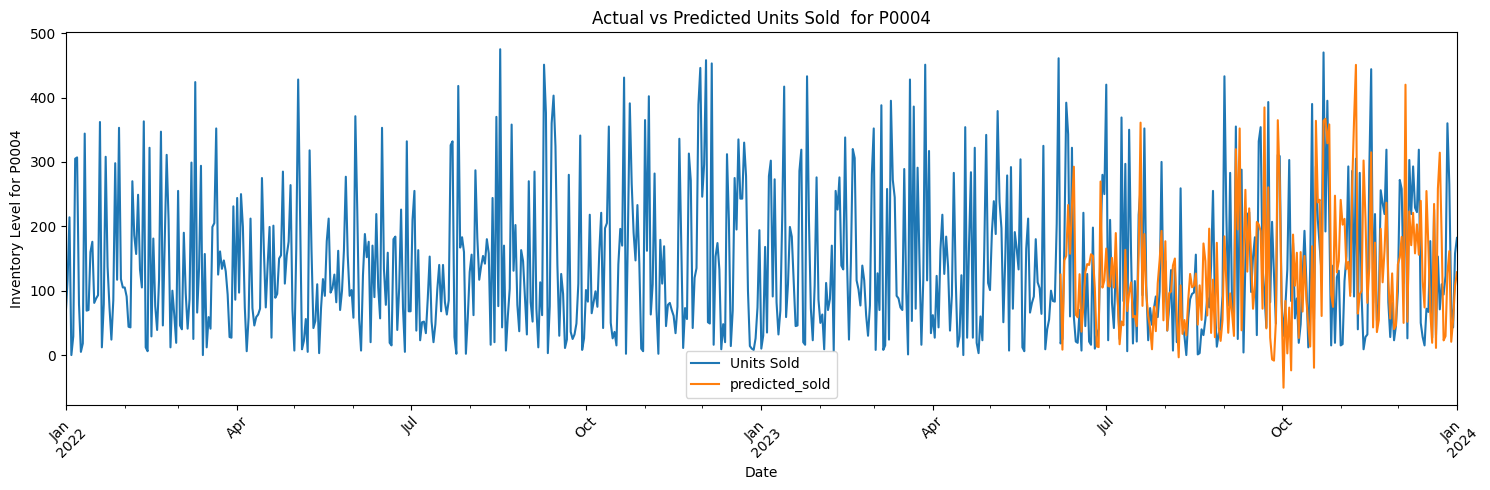


Mean Squared Error for  P0004=83.44926038769444



/var/folders/_z/0s1nj30n17q95bnhv10ll0500000gn/T/ipykernel_22993/2343077967.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["predicted_sold"]=reg.predict(X_test)


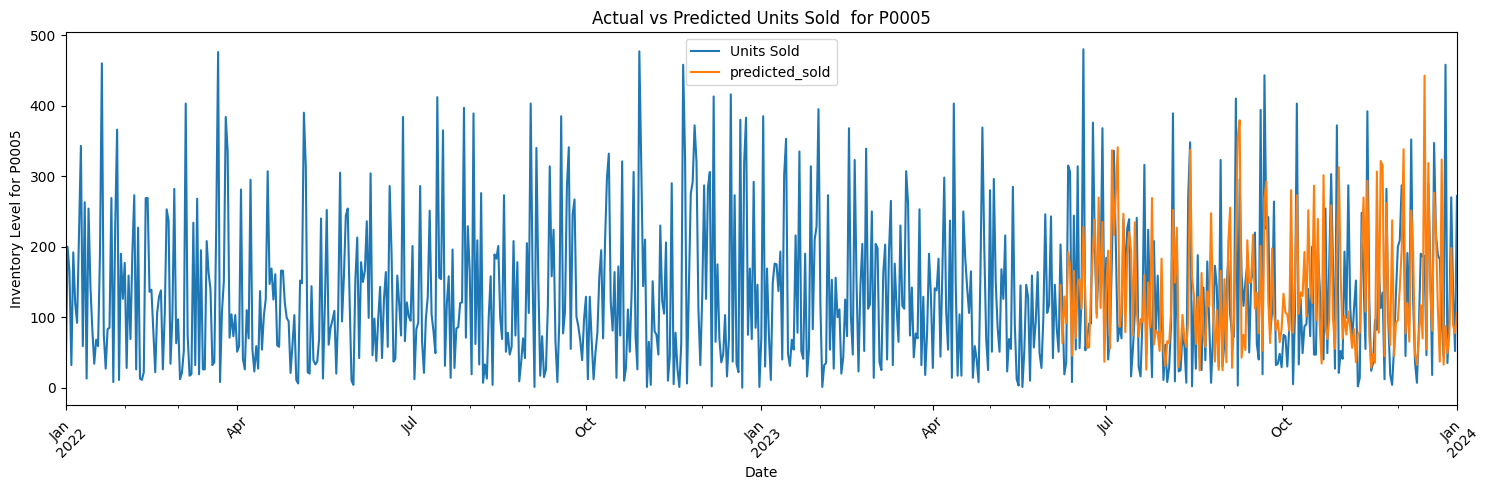


Mean Squared Error for  P0005=79.00083555559222



/var/folders/_z/0s1nj30n17q95bnhv10ll0500000gn/T/ipykernel_22993/2343077967.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["predicted_sold"]=reg.predict(X_test)


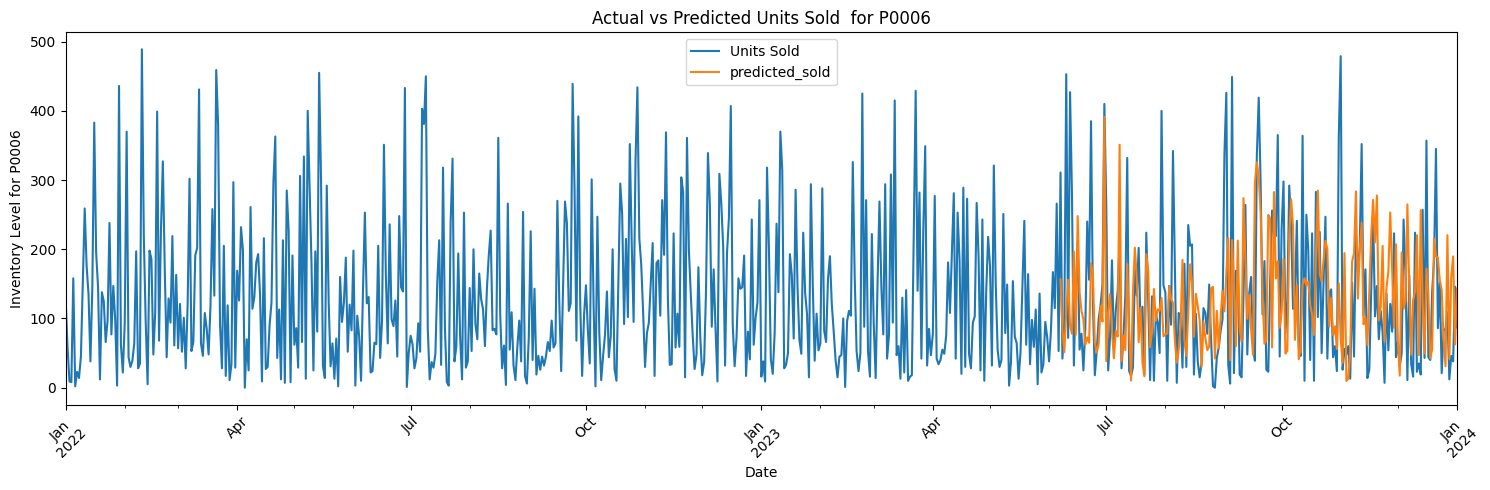


Mean Squared Error for  P0006=83.46099456075275



/var/folders/_z/0s1nj30n17q95bnhv10ll0500000gn/T/ipykernel_22993/2343077967.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["predicted_sold"]=reg.predict(X_test)


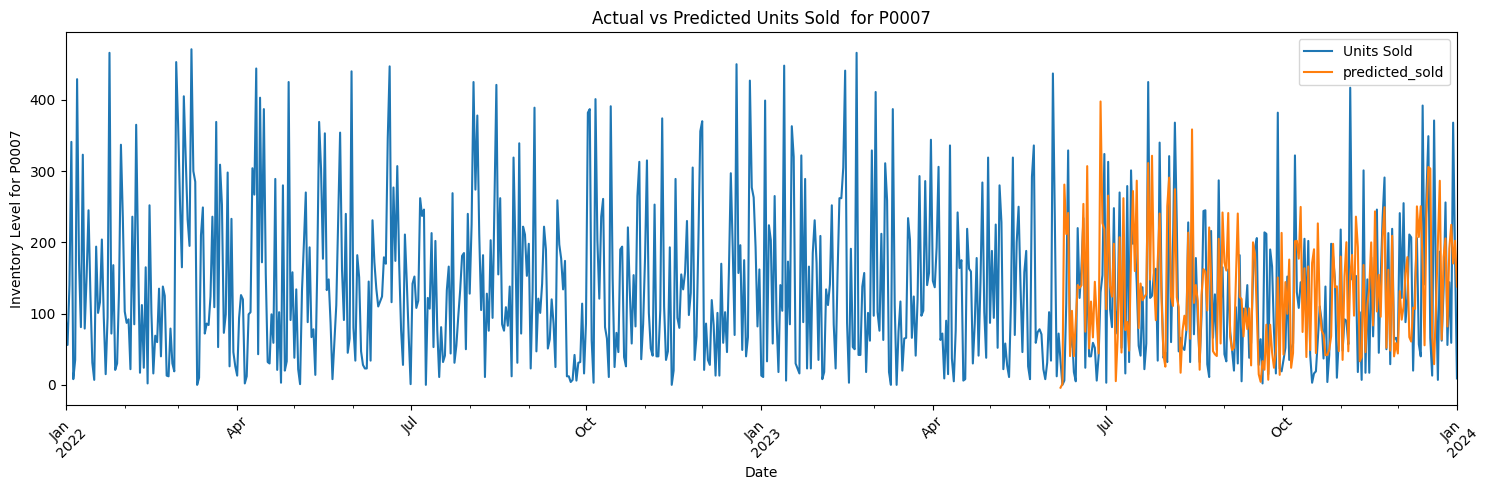


Mean Squared Error for  P0007=72.94285571004785



/var/folders/_z/0s1nj30n17q95bnhv10ll0500000gn/T/ipykernel_22993/2343077967.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["predicted_sold"]=reg.predict(X_test)


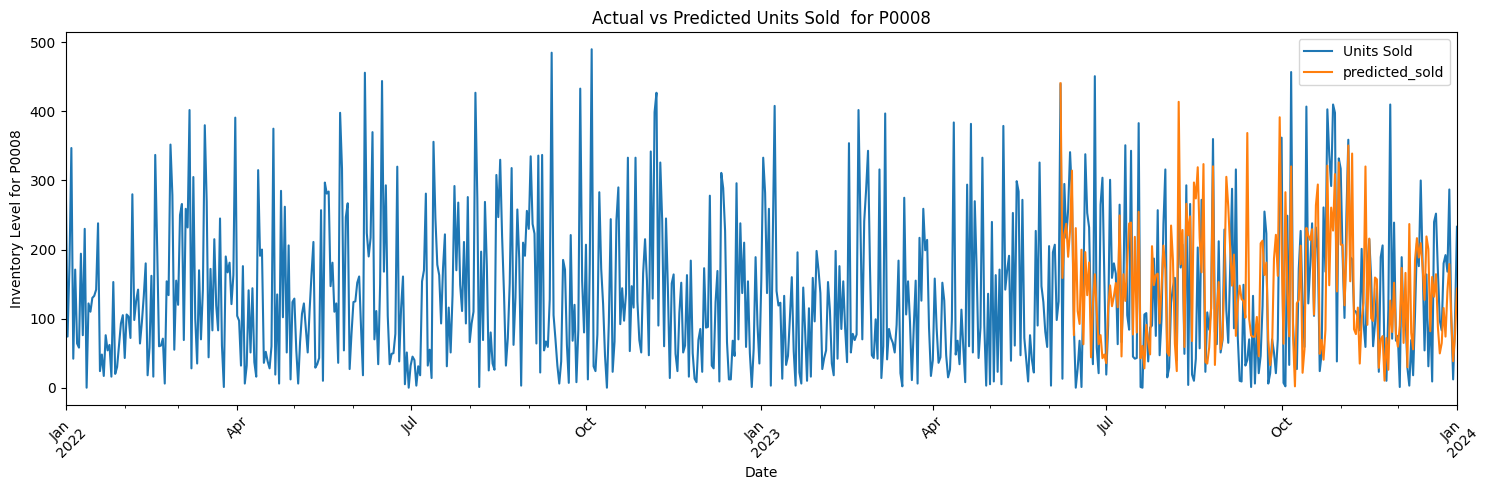


Mean Squared Error for  P0008=77.98090377892034



/var/folders/_z/0s1nj30n17q95bnhv10ll0500000gn/T/ipykernel_22993/2343077967.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["predicted_sold"]=reg.predict(X_test)


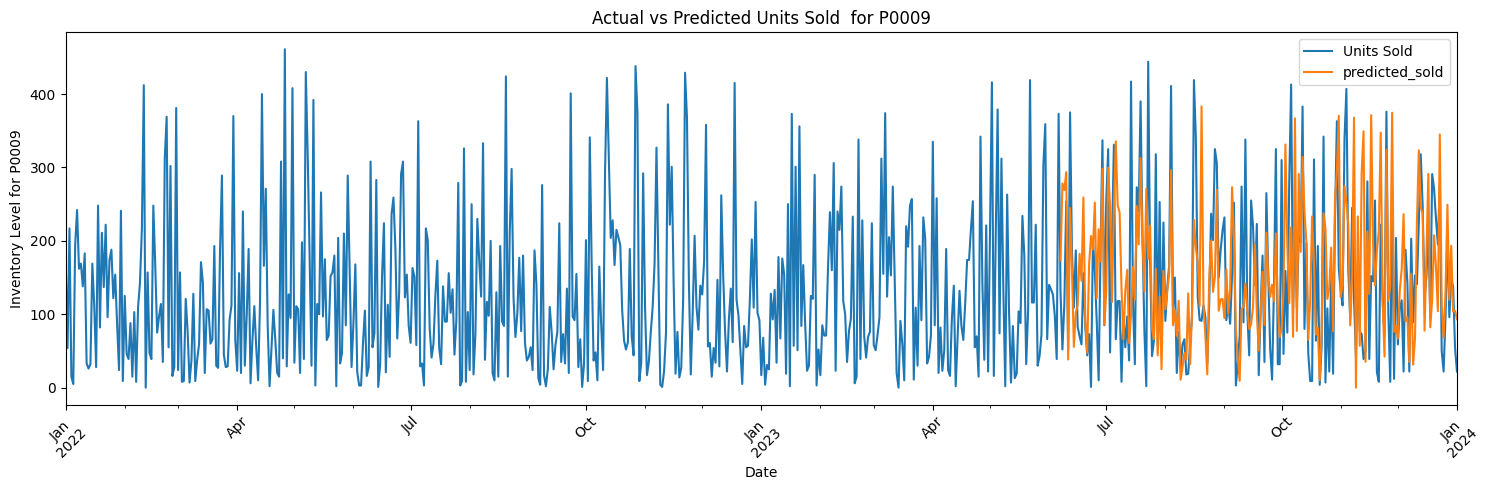


Mean Squared Error for  P0009=79.33712819559972



/var/folders/_z/0s1nj30n17q95bnhv10ll0500000gn/T/ipykernel_22993/2343077967.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["predicted_sold"]=reg.predict(X_test)


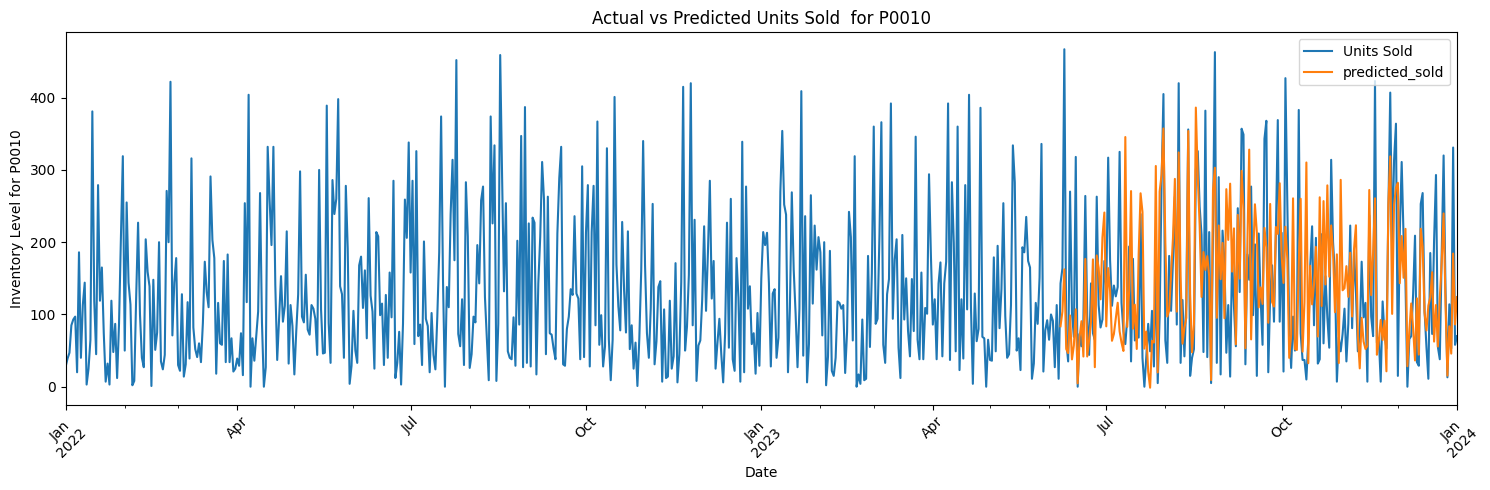


Mean Squared Error for  P0010=77.21013525171143



/var/folders/_z/0s1nj30n17q95bnhv10ll0500000gn/T/ipykernel_22993/2343077967.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["predicted_sold"]=reg.predict(X_test)


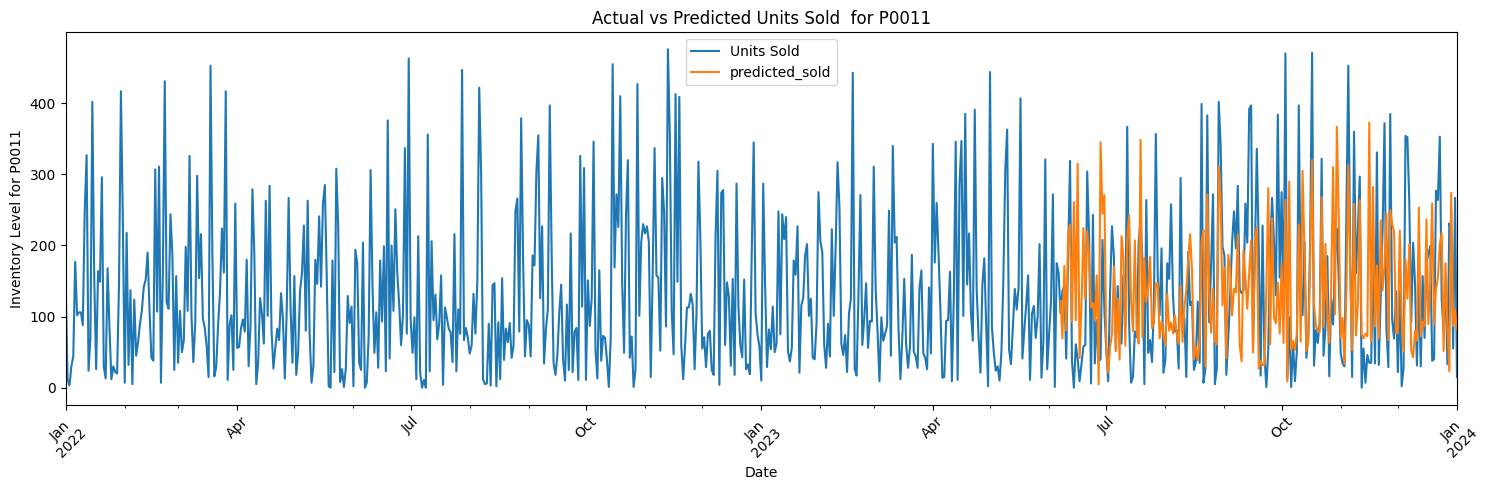


Mean Squared Error for  P0011=84.76362078269703



/var/folders/_z/0s1nj30n17q95bnhv10ll0500000gn/T/ipykernel_22993/2343077967.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["predicted_sold"]=reg.predict(X_test)


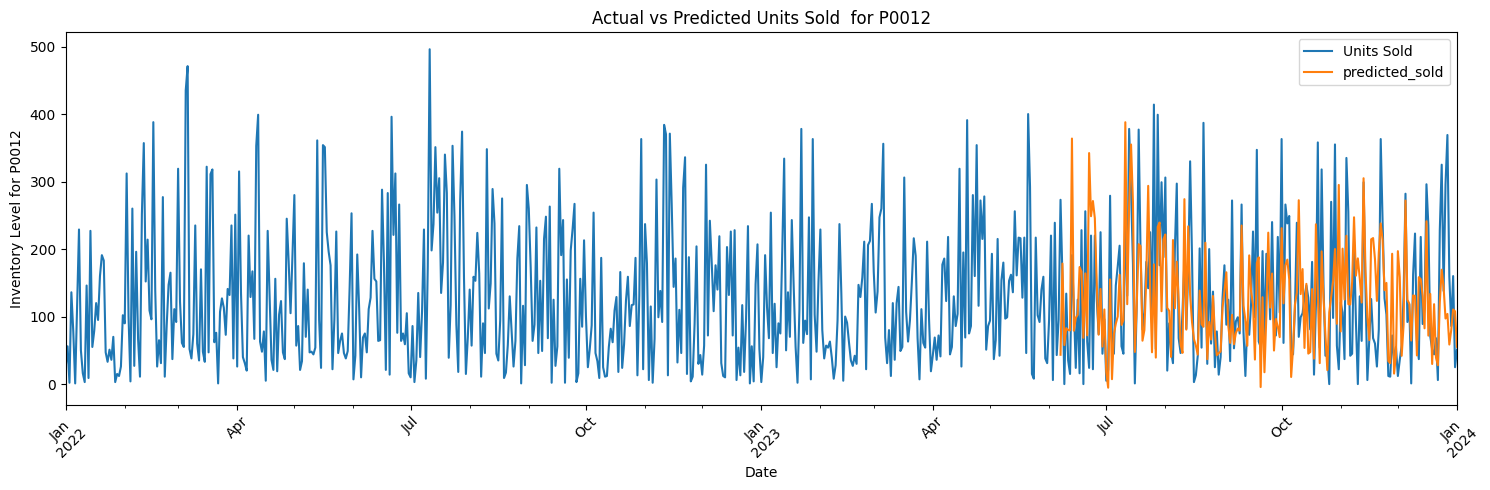


Mean Squared Error for  P0012=70.7352678787195



/var/folders/_z/0s1nj30n17q95bnhv10ll0500000gn/T/ipykernel_22993/2343077967.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["predicted_sold"]=reg.predict(X_test)


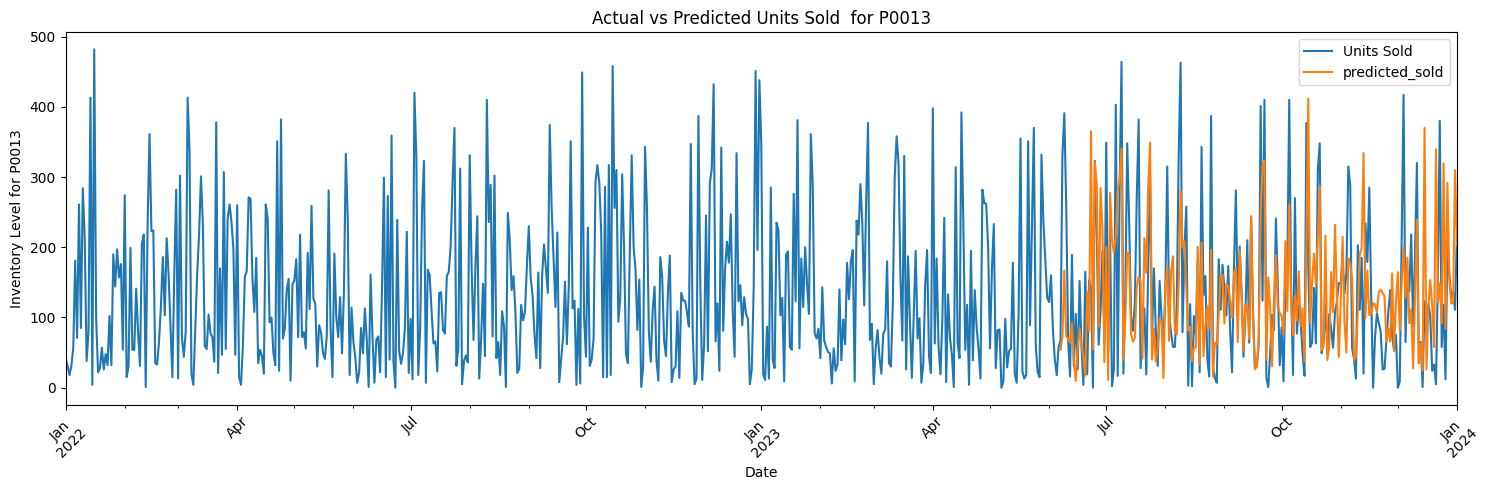


Mean Squared Error for  P0013=73.99449034512898



/var/folders/_z/0s1nj30n17q95bnhv10ll0500000gn/T/ipykernel_22993/2343077967.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["predicted_sold"]=reg.predict(X_test)


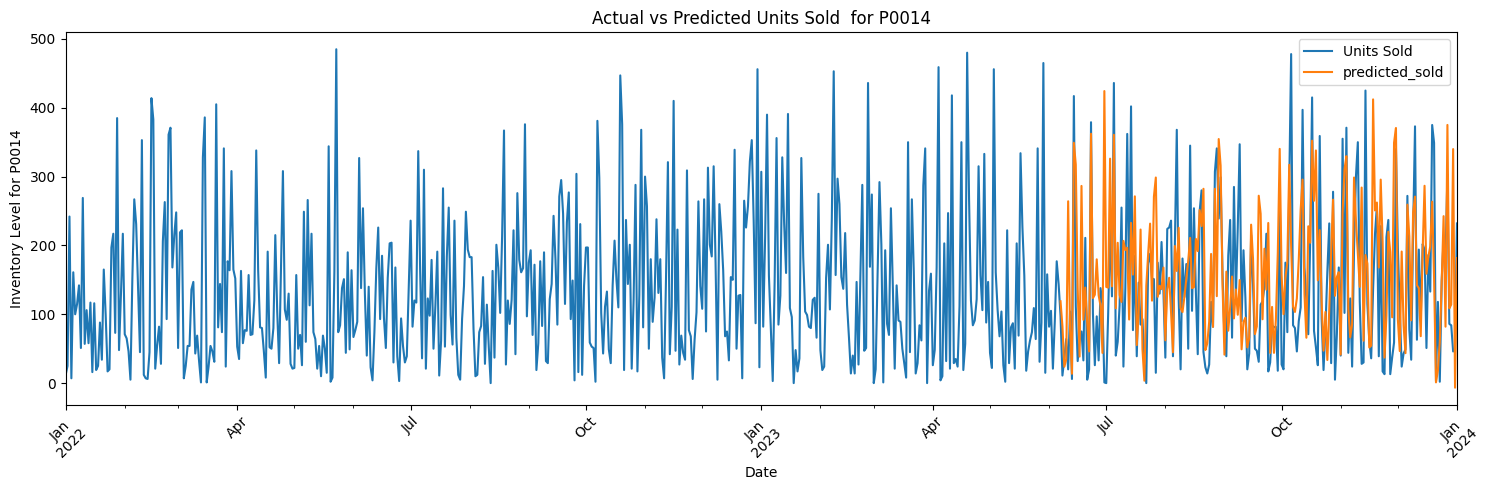


Mean Squared Error for  P0014=83.6128437501962



/var/folders/_z/0s1nj30n17q95bnhv10ll0500000gn/T/ipykernel_22993/2343077967.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["predicted_sold"]=reg.predict(X_test)


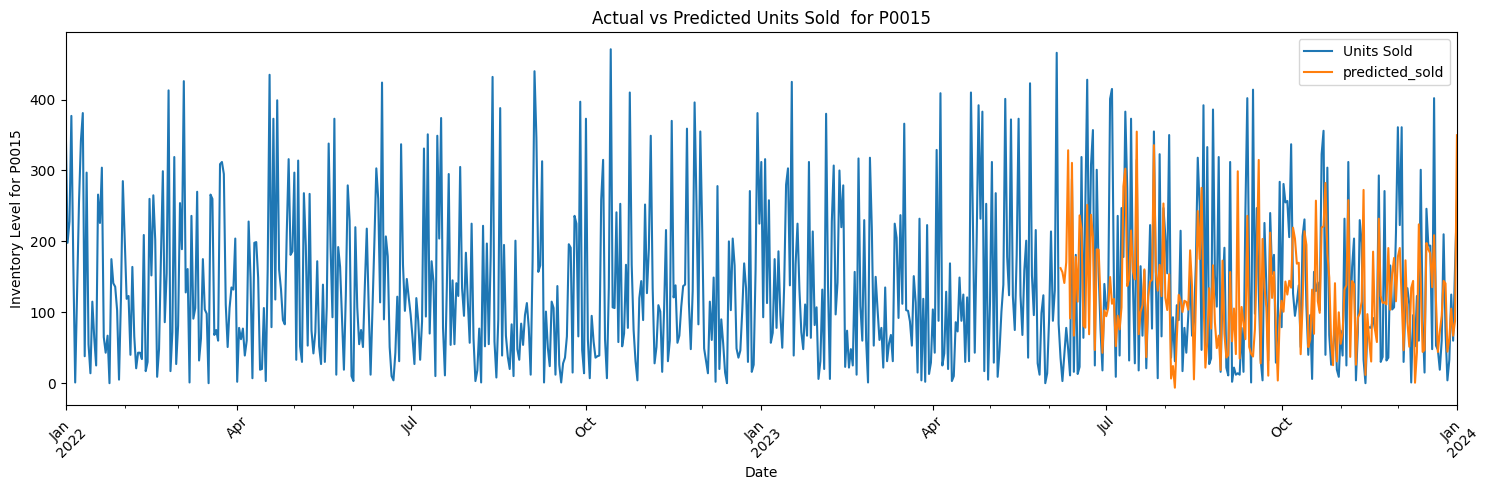


Mean Squared Error for  P0015=81.87445885655983



/var/folders/_z/0s1nj30n17q95bnhv10ll0500000gn/T/ipykernel_22993/2343077967.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["predicted_sold"]=reg.predict(X_test)


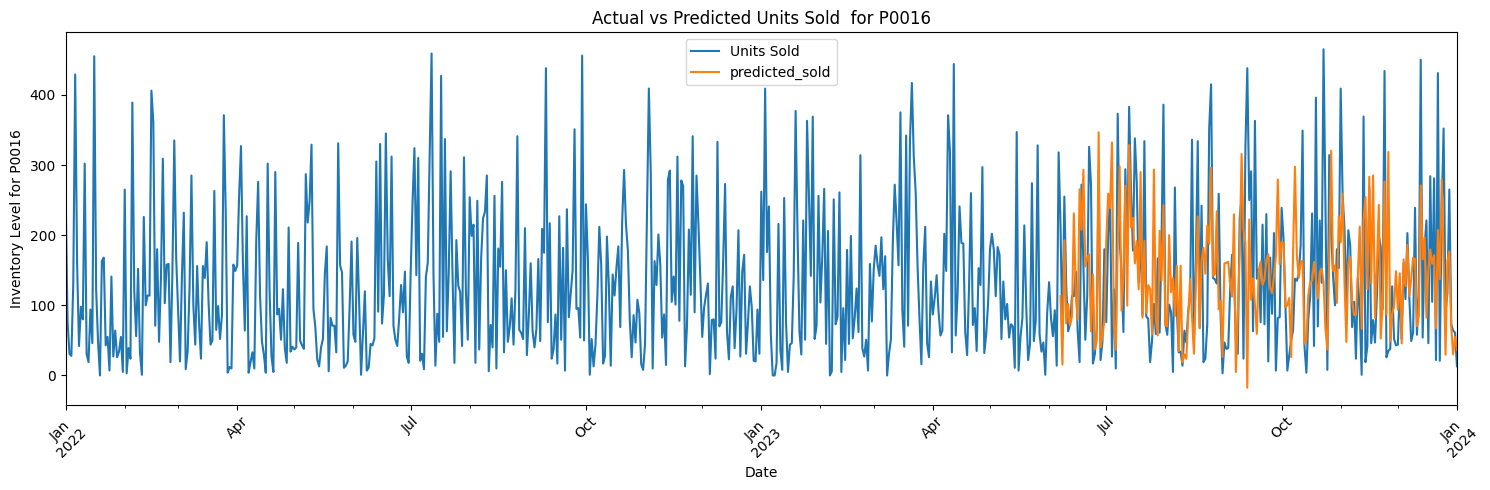


Mean Squared Error for  P0016=80.69293202167492



/var/folders/_z/0s1nj30n17q95bnhv10ll0500000gn/T/ipykernel_22993/2343077967.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["predicted_sold"]=reg.predict(X_test)


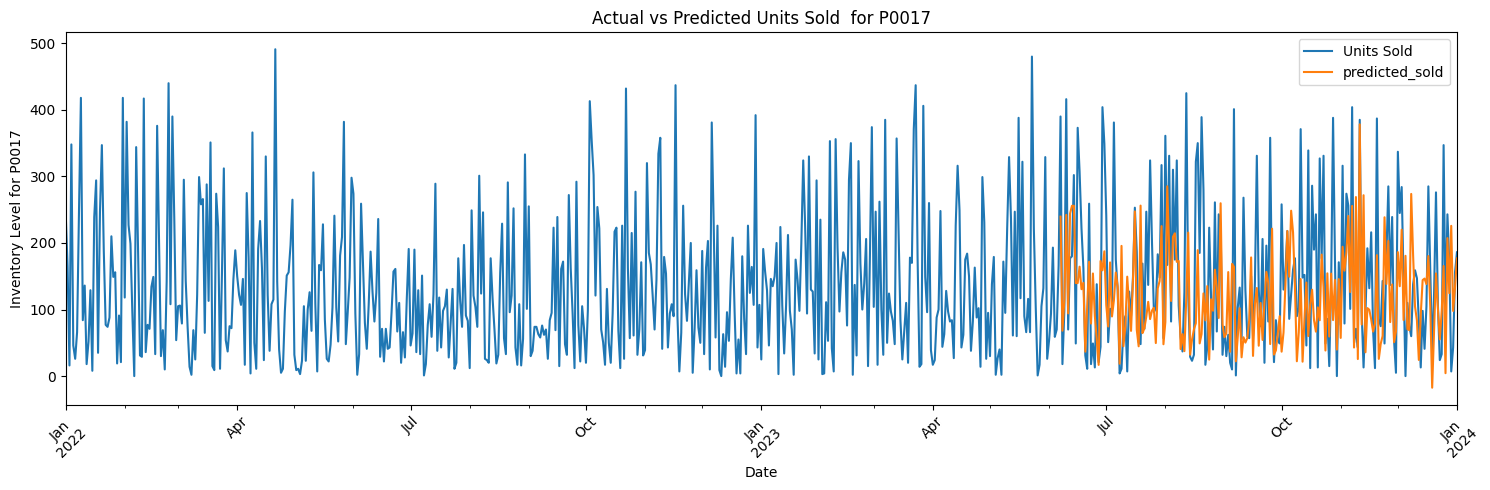


Mean Squared Error for  P0017=85.51338047730296



/var/folders/_z/0s1nj30n17q95bnhv10ll0500000gn/T/ipykernel_22993/2343077967.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["predicted_sold"]=reg.predict(X_test)


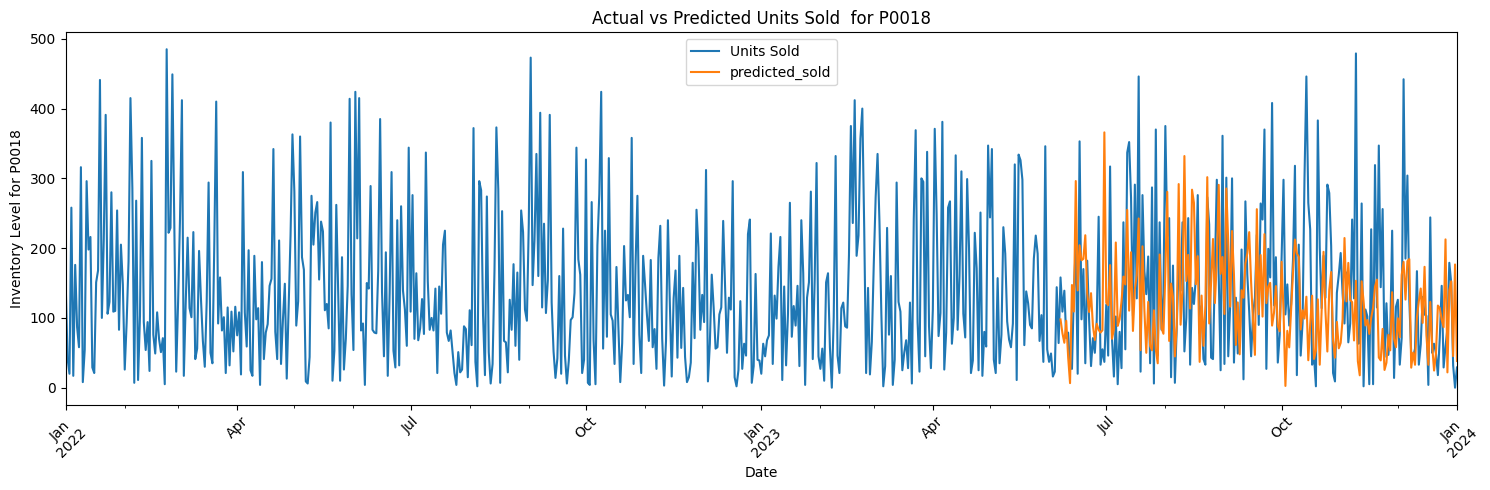


Mean Squared Error for  P0018=82.9897148700422



/var/folders/_z/0s1nj30n17q95bnhv10ll0500000gn/T/ipykernel_22993/2343077967.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["predicted_sold"]=reg.predict(X_test)


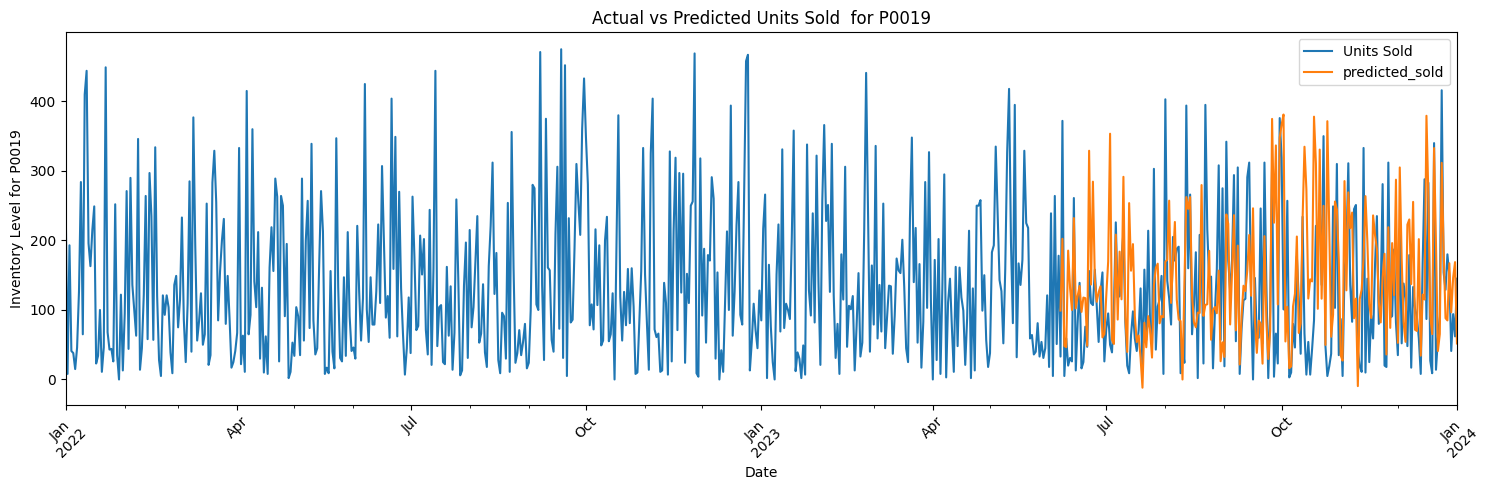


Mean Squared Error for  P0019=83.37258674012737



/var/folders/_z/0s1nj30n17q95bnhv10ll0500000gn/T/ipykernel_22993/2343077967.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["predicted_sold"]=reg.predict(X_test)


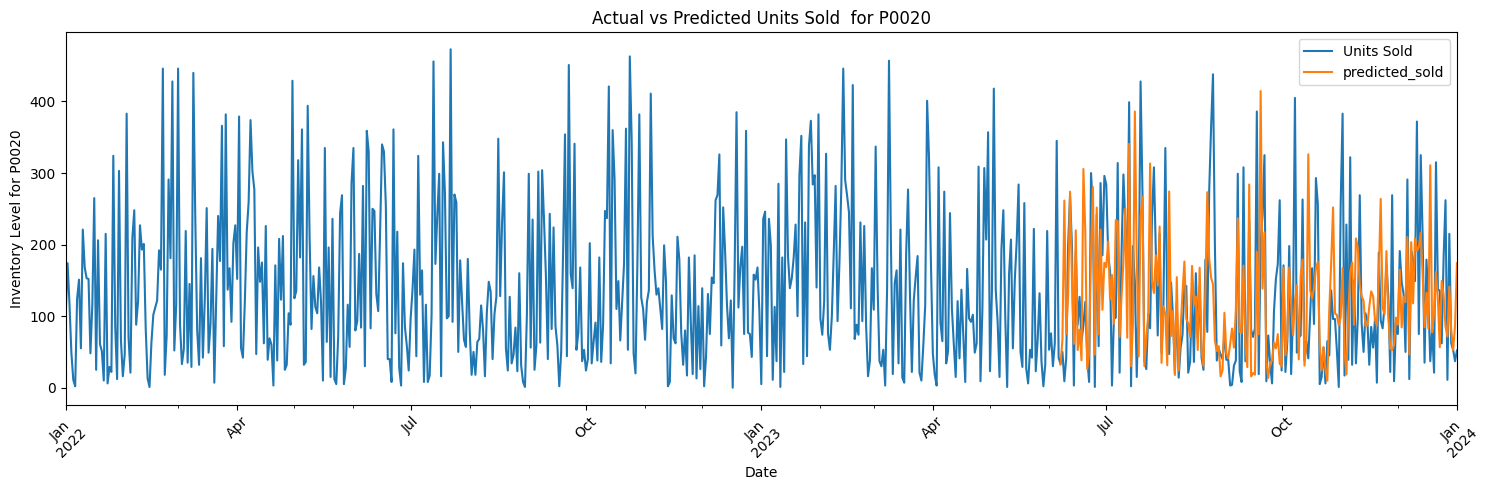


Mean Squared Error for  P0020=71.1685868176547



In [26]:
list_product=unique_values(data,"Product ID")

for x in list_product:
    plot_each_product_demand(data,x)

In [56]:
# Step 1: Prepare the Data for Forecasting
last_date = data['Date'].max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

# Create a DataFrame for future dates
future_data = pd.DataFrame({'Date': future_dates})

# Generate cyclical features for the future dates
future_data['year'] = future_data['Date'].dt.year
future_data['month'] = future_data['Date'].dt.month
future_data['day'] = future_data['Date'].dt.day
future_data['day_of_year'] = future_data['Date'].dt.dayofyear
future_data['week_of_year'] = future_data['Date'].dt.isocalendar().week
future_data['quarter'] = future_data['Date'].dt.quarter
future_data['season'] = (future_data['month'] % 12 // 3 + 1)

# Cyclical encoding
days_in_month = 30
future_data['month_sin'] = np.sin(2 * np.pi * future_data['month'] / 12)
future_data['month_cos'] = np.cos(2 * np.pi * future_data['month'] / 12)

future_data['day_sin'] = np.sin(2 * np.pi * future_data['day'] / days_in_month)
future_data['day_cos'] = np.cos(2 * np.pi * future_data['day'] / days_in_month)

days_in_year = 365
future_data['day_of_year_sin'] = np.sin(2 * np.pi * future_data['day_of_year'] / days_in_year)
future_data['day_of_year_cos'] = np.cos(2 * np.pi * future_data['day_of_year'] / days_in_year)

weeks_in_year = 52.1429
future_data['week_of_year_sin'] = np.sin(2 * np.pi * future_data['week_of_year'] / weeks_in_year)
future_data['week_of_year_cos'] = np.cos(2 * np.pi * future_data['week_of_year'] / weeks_in_year)

quarters_in_year = 4
future_data['quarter_sin'] = np.sin(2 * np.pi * future_data['quarter'] / quarters_in_year)
future_data['quarter_cos'] = np.cos(2 * np.pi * future_data['quarter'] / quarters_in_year)

seasons_in_year = 4
future_data['season_sin'] = np.sin(2 * np.pi * future_data['season'] / seasons_in_year)
future_data['season_cos'] = np.cos(2 * np.pi * future_data['season'] / seasons_in_year)

In [57]:
# Step 3: Make Predictions
# Select the same features used for training
X_future=future_data.select_dtypes(include="float64") 

In [58]:
future = X_future[['month_sin', 'month_cos', 'day_sin', 'day_cos', 'day_of_year_sin', 'day_of_year_cos', 'week_of_year_sin', 'week_of_year_cos', 'quarter_sin', 'quarter_cos', 'season_sin', 'season_cos']]

In [59]:
# Predict using the trained model
future_data['predicted_units_sold'] = reg.predict(future)

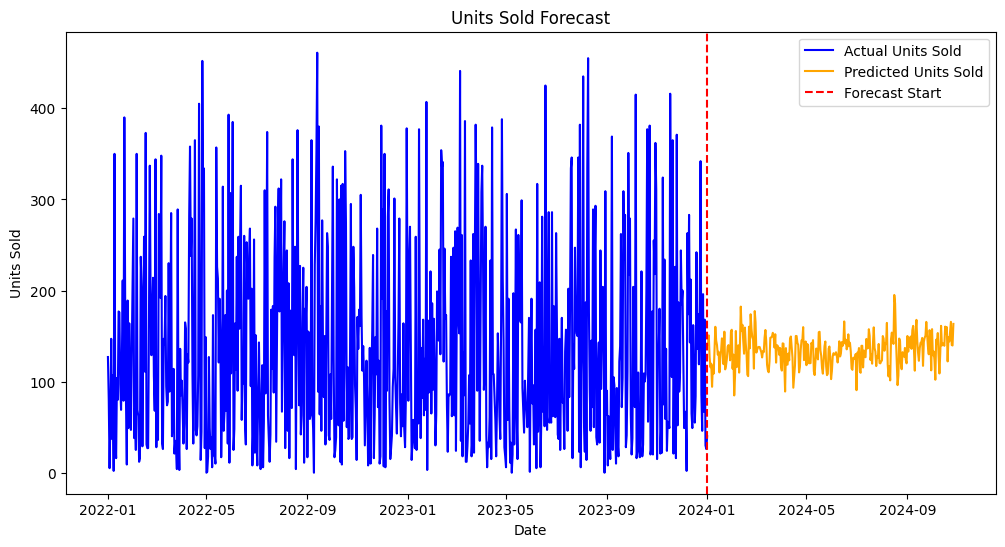

In [60]:
# Assuming 'data' is your original DataFrame
historical_data = data[['Date', 'Units Sold', 'Product ID']]

# Group by 'Date' and 'Product ID' and sum the 'Units Sold'
grouped_data = historical_data.groupby(['Date', 'Product ID']).sum()

# Filter for 'Product ID' == 'P0001'
filtered_data = grouped_data.groupby(level='Product ID').get_group('P0001')


# Step 4: Visualize the Results
# Combine the historical data with the forecast
# historical_data = data[['Date', 'Units Sold']]
historical_data = filtered_data.rename(columns={'Units Sold': 'actual_units_sold'})
forecast_data = future_data[['Date', 'predicted_units_sold']]

# Merge historical and forecast data
combined_data = pd.merge(historical_data, forecast_data, on='Date', how='outer')

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(combined_data['Date'], combined_data['actual_units_sold'], label='Actual Units Sold', color='blue')
plt.plot(combined_data['Date'], combined_data['predicted_units_sold'], label='Predicted Units Sold', color='orange')
plt.axvline(x=last_date, color='red', linestyle='--', label='Forecast Start')
plt.title('Units Sold Forecast')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.legend()
plt.show()

In [61]:
combined_data

Date  actual_units_sold  predicted_units_sold
0    2022-01-01              127.0                   NaN
1    2022-01-02               81.0                   NaN
2    2022-01-03                5.0                   NaN
3    2022-01-04               58.0                   NaN
4    2022-01-05              147.0                   NaN
...         ...                ...                   ...
1026 2024-10-23                NaN            154.522263
1027 2024-10-24                NaN            165.623123
1028 2024-10-25                NaN            140.167786
1029 2024-10-26                NaN            139.661179
1030 2024-10-27                NaN            163.359207

[1031 rows x 3 columns]